In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [2]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)

In [3]:
# Scale Data
from sklearn.preprocessing import StandardScaler
numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)
scaled_data.shape

(129, 102)

In [10]:
def plot_hist(history):
    '''Repurposed from https://www.tensorflow.org/tutorials/images/transfer_learning#learning_curves'''
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

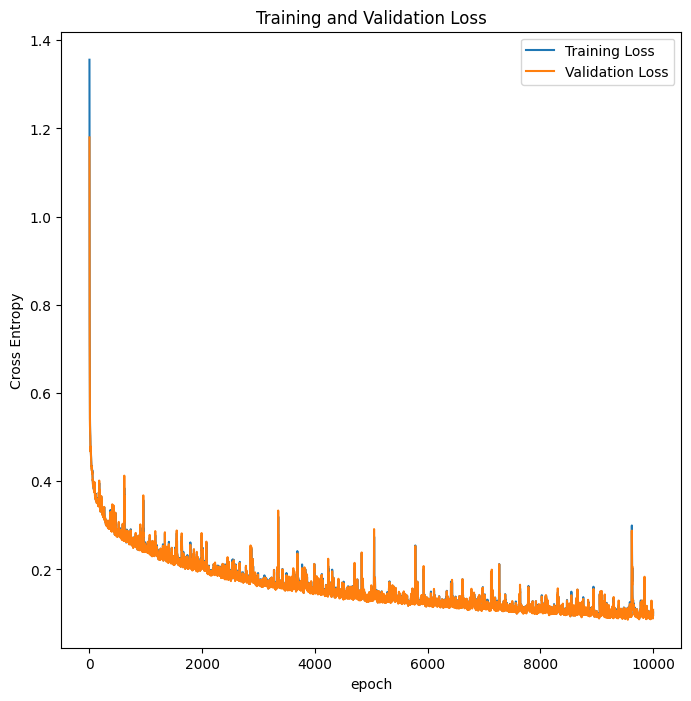

In [11]:
# Use Autoencoder to reduce dimensionality
num_dimensions = 2

encoder = keras.models.Sequential([
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(32, activation="selu"),
    keras.layers.Dense(16, activation="selu"),
    keras.layers.Dense(num_dimensions, activation="selu")
])

decoder = keras.models.Sequential([
    keras.layers.Dense(16, activation="selu", input_shape=[num_dimensions]),
    keras.layers.Dense(32, activation="selu", input_shape=[num_dimensions]),
    keras.layers.Dense(64, activation="selu", input_shape=[num_dimensions]),
    keras.layers.Dense(scaled_data.shape[1], activation="selu")
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(optimizer="adam", loss="mse")
history = autoencoder.fit(scaled_data, scaled_data, epochs=10000, validation_data=[scaled_data, scaled_data], verbose=0)
plot_hist(history)

5/5 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Autoencoded Data with Bank Score')

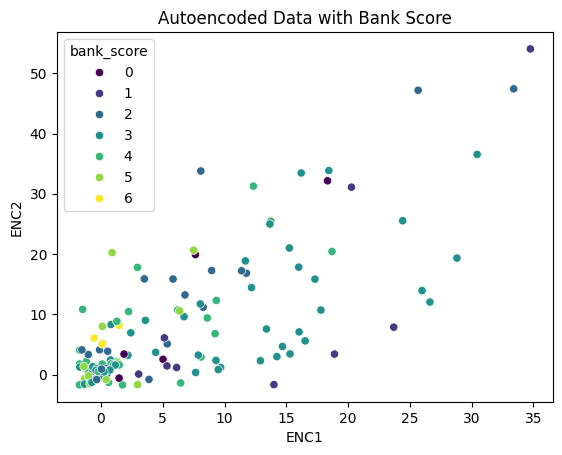

In [14]:
encoded_data = encoder.predict(scaled_data)

encoded_df = pd.DataFrame(encoded_data, columns=['ENC1', 'ENC2'])

score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
encoded_df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

plt.figure()
sns.scatterplot(
    x="ENC1", y="ENC2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=encoded_df,
    legend="auto"
)

plt.title("Autoencoded Data with Bank Score")